In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

## 1. Import data

In [43]:
data = pd.read_csv('loan_cleaned_data_final.csv')

## 2. Split data into the input features and output class

In [44]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,revol_bal,revol_util,total_acc,Verified,36 months,A to C,Own,5 years and below,more than 5 years,debt_consolidation
0,5000,5000,4975.0,10.65,162.87,24.000,27.65,0,1,3,...,13648,83.7,9,1,1,1,0,0,1,0
1,2500,2500,2500.0,15.27,59.83,30.000,1.00,0,5,3,...,1687,9.4,4,1,0,1,0,1,0,0
2,2400,2400,2400.0,15.96,84.33,12.252,8.72,0,2,2,...,2956,98.5,10,0,1,1,0,0,1,0
3,5000,5000,5000.0,7.90,156.46,36.000,11.20,0,3,9,...,7963,28.3,12,1,1,1,0,1,0,0
4,3000,3000,3000.0,18.64,109.43,48.000,5.35,0,2,4,...,8221,87.5,4,1,1,0,0,0,1,0


## 3. Finding optimum depth

In [45]:
def generate_auc(X,y,clf_class,**kwargs):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

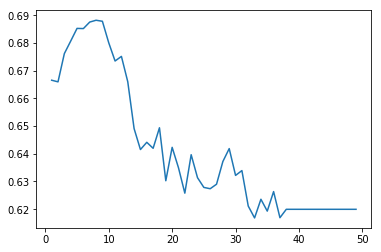

Optimal Decision Tree Depth: 8.0000000000


In [46]:
scores=[]
depths = range(1,50)
for n in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,RandomForestClassifier, max_depth=n, random_state=42)
    scores.append(roc_auc)

n_opt=depths[np.argmax(scores)]    

plt.plot(depths,scores)
plt.show()
print('Optimal Decision Tree Depth: %.10f' % n_opt)

## 4. Split data into test and training data

In [47]:
# split into test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## 5. Train and test model

In [48]:
# create model
clf = RandomForestClassifier(max_depth=n_opt, random_state=42)

# train model
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## 6. Score model

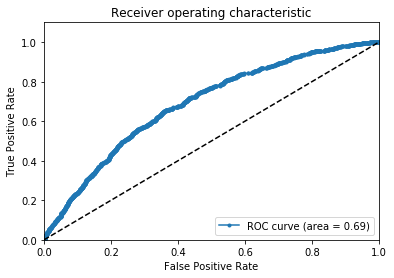

Area under the ROC curve : 0.688219


In [49]:
# Generate ROC 
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,RandomForestClassifier, max_depth=n_opt, random_state=42)
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

## 7. Cross-validate model

In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5, scoring="roc_auc")
scores

array([ 0.69228543,  0.67787542,  0.6776415 ,  0.65840256,  0.68749189])

## 8. Export model

In [51]:
joblib.dump(clf, 'loan_random_forest_predictor.pkl') 

['loan_random_forest_predictor.pkl']